In [1]:
import os
import sys
import numpy as np
import itertools
import matplotlib.pyplot as plt
from math import pi
import orbithunter as orb
import inspect
import orbithunter.ks as ks
import h5py
import time
from matplotlib import gridspec
import pandas as pd

# Covering space-time, an investigation.


# Table of contents
<a id='toc'></a>

## [A. Function declarations](#func)

## [B. Glossary](#glossary)

## [1. Introduction](#intro)

## [2. Family overlap](#family)

## [3. Group orbit overlap](#grouporbit)
    
## [4. Minimal covers](#minimal)

###  [4.a fundamental_domain==False](#minimal0)
###  [4.b fundamental_domain==True](#minimal1)

## [5. Current difficulties](#results)


<a id='func'></a>
# A. Function declarations.
Some of these are deprecated; work in progress

In [2]:
def minimal_covering_set(covering, cover_threshold=0.99, verbose=True, dtype=int):
    """ Find the smallest number of masks which cover a specified proportion of the total cover area."""
    assert cover_threshold < 1, 'cover threshold must be provided as a float between (0, 1).'
    total_mask = covering.any(axis=0)
    area_covered = total_mask.astype(bool).sum()
    # Find the orbit mask with the largest covering.
    sites_covered = covering.sum(axis=tuple(range(1, len(covering.shape))))
    minimal_indices = []
    max_area_cover_index = np.argmin(sites_covered)
    minimal_cover_mask_indices = np.zeros(covering.shape[0], dtype=bool)
    minimal_cover_mask_indices[max_area_cover_index] = True
    cover_percentage = covering[minimal_cover_mask_indices, ...].any(axis=0).astype(bool).sum() / total_mask.astype(bool).sum()
    # If the cover percentage is less than the provided threshold, then look for more masks to add.
    
    if verbose:
        print(sum(minimal_cover_mask_indices), cover_percentage)
    percentages = []
    percentages.append(cover_percentage)
    while cover_percentage < cover_threshold:
        # the next mask best mask is the one which covers the most area not covered by the current mask. 
        orthogonalities = []
        # The current union of masks included
        minimal_cover = covering[minimal_cover_mask_indices, ...].any(axis=0)
        # The current masks not included. 
        complement_cover = covering[np.invert(minimal_cover_mask_indices), ...]
        # Use broadcasting to get the intersection with each excluded mask.
        currently_uncovered = (complement_cover & ~minimal_cover)
        # Find the next best mask to add by totaling the number of points it covers which are not in minimal cover yet. 
        next_greatest_contribution = np.argmax(currently_uncovered.sum(axis=tuple(range(1, len(covering.base.shape)+1))))
        # demarcate the newer member of the cover. 
        minimal_cover_mask_indices[next_greatest_contribution] = True
        

        # Calculate the amount of area covered with inclusion of the next mask. 
        cover_percentage = (covering[minimal_cover_mask_indices, ...].astype(bool).any(axis=0).sum() 
                            / total_mask.astype(bool).sum())
        percentages.append(cover_percentage)
        if verbose:
            print(sum(minimal_cover_mask_indices), cover_percentage)
    return minimal_cover_mask_indices, percentages

In [3]:
def plot_covering_families(covering, base, windows, verbose=True, figsize=(6,6)):
    """ Given a covering, plot its constituents or plot its union, w"""

    covering_percentages = []
    for mask_key in covering:
        if covering[mask_key].shape != base.shape:
            covering_mask = scanning_mask(covering[mask_key], base, windows[int(mask_key)], strides)
        else:
            covering_mask = covering[mask_key]
        bool_mask = covering_mask.astype(bool).copy()
        bool_mask[bool_mask!=0]=1
        covering_percentage = covering_mask.astype(bool).sum()/covering_mask.size
        print('{}% space-time covered by orbit {}'.format(100*covering_percentage, mask_key))
        fig = plt.figure(figsize=figsize) 
        gs = gridspec.GridSpec(1, 2, width_ratios=[1, 5]) 
        ax0 = plt.subplot(gs[0])
        ax0.imshow(windows[int(mask_key)].state, cmap='jet')
        ax1 = plt.subplot(gs[1])
        im = ax1.imshow(np.ma.masked_array(base.state, mask=np.invert(bool_mask.astype(bool))), cmap='jet')
        _ = plt.show()
        _ = plt.close()
        print('##############')
        
def plot_covering_union(covering, base, windows, strides=(1,1), verbose=True, figsize=(6,6)):
        covering_mask = covering_union(covering, base, windows, strides)
        bool_mask = covering_mask.astype(bool).copy()
        bool_mask[bool_mask!=0]=1
#         base.plot(figsize=figsize)
#         base.__class__(state=np.ma.masked_array(base.state, mask=bool_mask, fill_value=np.nan),
#                                      basis='field', parameters=base.parameters).plot(figsize=figsize)
        base.__class__(state=np.ma.masked_array(base.state, mask=np.invert(bool_mask.astype(bool)), fill_value=np.nan),
                                     basis='field', parameters=base.parameters).plot(figsize=figsize)

In [4]:
from ipywidgets import interact, interactive, fixed, interact_manual, HBox, VBox, widgets
# import plotly.graph_objs as go
import plotly.offline as py
import chart_studio.plotly as plotly
import seaborn as sns
import mpl_toolkits.mplot3d.art3d as art3d
from plotly.graph_objects import *
import matplotlib.pyplot as plt 
from matplotlib import gridspec

In [5]:
invert=True
def interactwrapper(orbit_cover_instance, trimmed_scores=None, mapped_scores=None, **kwargs):
    mindex = kwargs.get('mindex', 0)
    maxdex = kwargs.get('maxdex', len(orbit_cover_instance.windows)-1)
    windows = orbit_cover_instance.windows
    if trimmed_scores is None:
        trimmed_scores = orbit_cover_instance.trim()
    if mapped_scores is None:
        mapped_scores = orbit_cover_instance.map()
    def update(orbit_index):
        nonlocal trimmed_scores
        nonlocal mapped_scores
        nonlocal windows
        fig = plt.figure(figsize=(20,20)) 
        gs = gridspec.GridSpec(3, 3, width_ratios=[20, 1, 20], height_ratios=[20, 1, 20]) 

        ax0 = plt.subplot(gs[:, 0])
        ax1 = plt.subplot(gs[:, 1])    
        ax2 = plt.subplot(gs[:, 2])
        ax1.imshow(windows[orbit_index].state, cmap='jet')

        scores = trimmed_scores[orbit_index]
        vmin = scores.min()
        vmax = scores[scores!=np.inf].max()

        invalid_masked = np.ma.masked_invalid(mapped_scores[orbit_index])
        masked_base = np.ma.masked_array(orbit_cover_instance.base.state, mask=invalid_masked.mask)
        im1 = ax0.imshow(scores, vmin=vmin, vmax=vmax, cmap='viridis')
        im2 = ax2.imshow(masked_base, cmap='jet')
        ax1.axis('off')
        ax0.set_xticklabels('')
        ax0.set_yticklabels('')
        ax2.set_xticklabels('')
        ax2.set_yticklabels('')
        fig.colorbar(im2, ax=ax2, shrink=0.3)
        fig.colorbar(im1, ax=ax0, shrink=0.3)
        plt.show()
    interact(update, orbit_index=widgets.IntSlider(min=mindex, max=maxdex, step=1, value=0));

<a id='glossary'></a>
# B. Glossary.


**Covering orbits** : The set of orbits whose shadowing constitutes the cover. 

**Cover** : The regions of space-time detected as shadowing of a set of periodic orbits, called the covering orbits.

**Minimal covering orbits** : A subset of the covering orbits which reproduces a certain proportion of the cover. 

**Minimal cover**: The space-time shadowed by the orbits in the minimal covering set. 

**Family**: A collection of orbits which are all related by continuation

**Group orbit**: The collection of equivariant orbits populated by applying symmetry operations to a single orbit, i.e. a single representative of a family. 

**[Return to table of contents](#toc)**

<a id='intro'></a>
# Introduction

With results from ```continuation.ipynb```, ```shadowing.ipynb``` and ```shadowing_statistics.ipynb``` we can begin to test the covering process. Even in the context of the "family" method for calculating covering, if the number of group orbit members for each family member in the covering is large, the computations for a single family on a single domain can take a *very* long time. Therefore, it behooves us to determine a subset of group orbit members which provide the most efficient covering, in terms of computational time per area. The idea here being that more orbit family members likely only contribute to overlaps. 

So, the main objective before beginning the full covering computations (i.e. determining the area proportions and statistical averages) is to first work through the following list of tasks:

    1. Determine an efficient number of members per family to use for covering
    2. Determine an efficient number of group members per family member to use for covering
    4. Determine how the different metrics affect these results 

The different metrics mentioned in this list include the $L_2$ norm of the difference between windows $|u-v|$, the "amplitude difference" $u^2-v^2$, and the bottleneck distance between persistence diagrams. Due to the pointwise nature of the first two metrics, it is likely that these will require many more group orbit members and family members than the bottleneck distance metric, which is topological in nature. While important, this last task of determining the best metric is covered only very briefly 

In [6]:
# patch_samples = orb.read_h5("./data/large_patches.h5", tuple(str(i)+'/' for i in list(range(1001))[::10]))

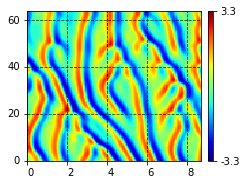

In [7]:
windows = [x.transform(to='field') for x in orb.read_h5('./data/minimal_cover.h5')]
base = orb.read_h5('./data/small_patches.h5', '0')
large_patch = orb.read_h5('./data/large_patch.h5')
base.plot()
strides=(1,1)
fundamental_windows = tuple([x.to_fundamental_domain() for x in windows])

Import critical values; the specificity of each key is somewhat annoying but it is not worth the effort of making this better. 

In [8]:
strictness = 1
critical_persistence_values = []
with h5py.File('./data/critical_values.h5', 'r') as file:
    critical_persistence_values.append(file['defect/bottleneck_distance_fundamental_domain'][...][strictness])
    critical_persistence_values.append(file['drifter/bottleneck_distance_fundamental_domain'][...][strictness])
    critical_persistence_values.append(file['large_defect/bottleneck_distance_fundamental_domain'][...][strictness])
    critical_persistence_values.append(file['wiggle/bottleneck_distance_fundamental_domain'][...][strictness])

critical_amp_diff_values = []
with h5py.File('./data/critical_values.h5', 'r') as file:
    critical_amp_diff_values.append(file['defect/amplitude_difference_fundamental_domain'][...][strictness])
    critical_amp_diff_values.append(file['drifter/amplitude_difference_fundamental_domain'][...][strictness])
    critical_amp_diff_values.append(file['large_defect/amplitude_difference_fundamental_domain'][...][strictness])
    critical_amp_diff_values.append(file['wiggle/amplitude_difference_fundamental_domain'][...][strictness])

critical_l2_diff_values = []
with h5py.File('./data/critical_values.h5', 'r') as file:
    critical_l2_diff_values.append(file['defect/l2_difference_fundamental_domain'][...][strictness])
    critical_l2_diff_values.append(file['drifter/l2_difference_fundamental_domain'][...][strictness])
    critical_l2_diff_values.append(file['large_defect/l2_difference_fundamental_domain'][...][strictness])
    critical_l2_diff_values.append(file['wiggle/l2_difference_fundamental_domain'][...][strictness])

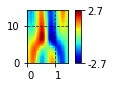

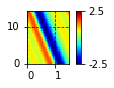

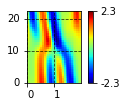

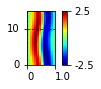

In [9]:
for x in fundamental_windows:
    x.plot()

[Return to table of contents](#toc)
# Preliminary testing

As a preliminary trial, run the covering routine with only a small set of covering orbits, not accounting for their
symmetry group orbits or continuous families. This will give an idea as to whether it will be possible to cover the space. Each fundamental orbit has a discretization of (32, 32) even though they do not have the same dimensions; simply for uniformity. however rectangular and different discretization sizes in a single ```cover``` function are allowed if replacement=True. I thought that I could improve performance by caching values during the persistent homology calculations but when the number of values in memory gets too large it actually becomes faster to recompute rather than search for values in an array. 

This calculation is "with replacement". No replacement means that once a detection has been made at a site, it will be skipped over for future orbits in the covering set. This is a cumulative process which reduces the numbers of computations for each successive orbit. The motivation being that a region of space-time only shadows a single orbit at a time, by definition. 
However, because we actually want to look at the overlaps that occur, replacement will be left on.

Overlaps are good and bad, depending on the context. They are bad when overlaps occur between different families, as the area which "belongs" to each family becomes undefined. Overlaps are good when they occur with respect to members of the same family and group orbits; this is an indication that the number of covering orbits can be reduced, because the information they provide is redundant. 


#### Metric comparison

First, with a small patch, check the performance of the different metrics as a simple guide for which one to use for the preliminary testing. First, use  bottleneck distance between persistence diagrams. This requires a custom input for the
scoring function; it must take base_slice, window orbits as its arguments, keyword arguments are allowed and it is
highly recommended that computations which are relatively expensive and only need to be computed once (i.e. the metric
is not pointwise) can be included using the ```window_cache``` keyword argument. To use ```window_cache```, a function
which computes this quantity ```window_caching_function``` must be supplied to ```cover```.

If using absolute threshold and not density, then need to have windows entirely within the boundary. 

In [10]:
t0ad=time.time_ns()/10**9

oc1 = orb.OrbitCover(large_patch,
                     fundamental_windows,
                     critical_amp_diff_values,
                     periodicity=(False, False),
                     replacement=False,
                     min_overlap = 1,
                     scoring_function=orb.scoring_functions('amplitude'),
                    )
oc1 = orb.cover(oc1, verbose=True)
t1ad=time.time_ns()/10**9
print('\nAmplitude metric covering took {:.2f} seconds to complete'.format(t1ad-t0ad))

--------------------
Amplitude metric covering took 84.12 seconds to complete


In [11]:
from time import time_ns
t0 = time_ns()/10**9
mapped_oc1 = oc1.map()
t1= time_ns()/10**9
print(t1-t0)

25.636840343475342


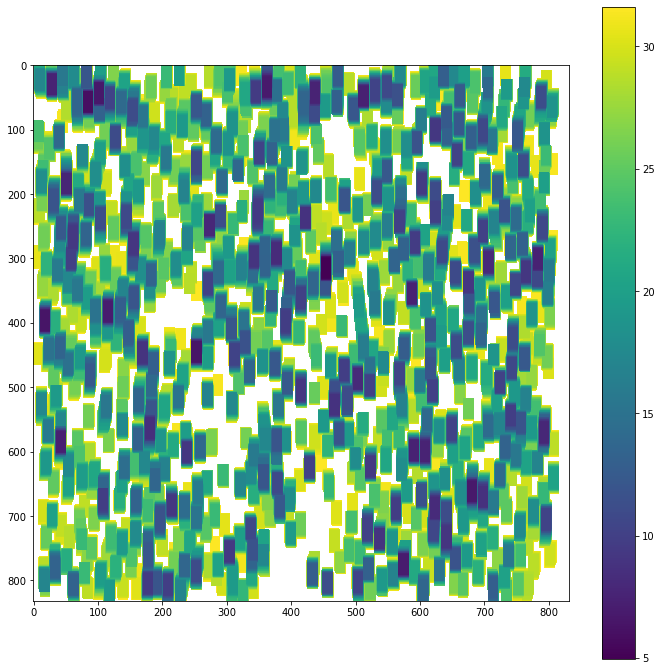

In [12]:
fig, ax = plt.subplots(figsize=(12,12))
im = ax.imshow(mapped_oc1[3], interpolation='none')
plt.colorbar(im, ax=ax)
plt.show()

In [13]:
# if len(oc1.scores.shape) == oc1.base.ndim:
#     # If a single score array, create a single index along axis=0 for iteration purposes.
#     scores = oc1.scores[np.newaxis, ...]
# else:
#     scores = oc1.scores

# oob_pivots = []

# # Only have to iterate once per unique discretization shape, take advantage of this.
# all_window_shapes = [tuple(w.discretization) for w in oc1.windows]

# # The bases orbit periodicity has to do with scoring and whether or not to wrap windows around.
# orbit_scores = np.full_like(
#     np.zeros([len(all_window_shapes), *oc1.padded_orbit.shape]), np.inf
# )

# # array_of_window_shapes = np.array(all_window_shapes)
# unique_window_shapes = set(all_window_shapes)
# # By iterating over shapes and not windows, cut down on
# for index, window_shape in enumerate(unique_window_shapes):
#     where_this_shape = tuple(
#         i for i, shape in enumerate(all_window_shapes) if shape == window_shape
#     )
#     # relevant_window_states = np.array([oc1.windows[i].state for i in where_this_shape])
#     # retrieve the function for scoring, using a default function based on the l2 difference.
#     threshold_broadcasting_reshape = tuple([-1] + (len(scores.shape) - 1) * [1])
#     window_grid = np.indices(window_shape)
#     # For each set of scores, only need to map pivot scores that are sub-threshold

#     mask_insufficient_scores = np.logical_not(scores[where_this_shape, ...] <= oc1.thresholds[np.array(where_this_shape)].reshape(
#                                                 *threshold_broadcasting_reshape))
#     break

# oc1.thresholds

# np.logical_not(scores[where_this_shape, ...]<= oc1.thresholds[np.array(where_this_shape)].reshape(
#                                                 *threshold_broadcasting_reshape)).shape

# oc1.thresholds[np.array(where_this_shape)].reshape(
#                 *threshold_broadcasting_reshape
#             )

# (scores[where_this_shape, ...] <= oc1.thresholds[np.array(where_this_shape)].reshape(*threshold_broadcasting_reshape)).shape

# scores[where_this_shape, ...][(scores[where_this_shape, ...] <= oc1.thresholds[np.array(where_this_shape)].reshape(*threshold_broadcasting_reshape))]

# scores[where_this_shape, ...]

#         np.any(
#             scores[where_this_shape, ...]
#             <= oc1.thresholds[np.array(where_this_shape)].reshape(
#                 *threshold_broadcasting_reshape
#             ),
#             axis=0,
#         )

# mask_insufficient_scores

In [14]:
t0l2=time.time_ns()/10**9
oc2 = orb.OrbitCover(large_patch,
                     fundamental_windows,
                     critical_l2_diff_values,
                     hull=None,
                     core=None,
                     mask=None,
                     periodicity=(False, True),
                     replacement=False,
                   min_overlap = 1,
                   scoring_function=orb.scoring_functions('l2')
                    )

oc2 = orb.cover(oc2, verbose=True)
t1l2=time.time_ns()/10**9
print('\nL2 metric covering took {:.2f} seconds to complete'.format(t1l2-t0l2))

-------------------
L2 metric covering took 104.82 seconds to complete


--------------------
L2 metric covering took 106.91 seconds to complete


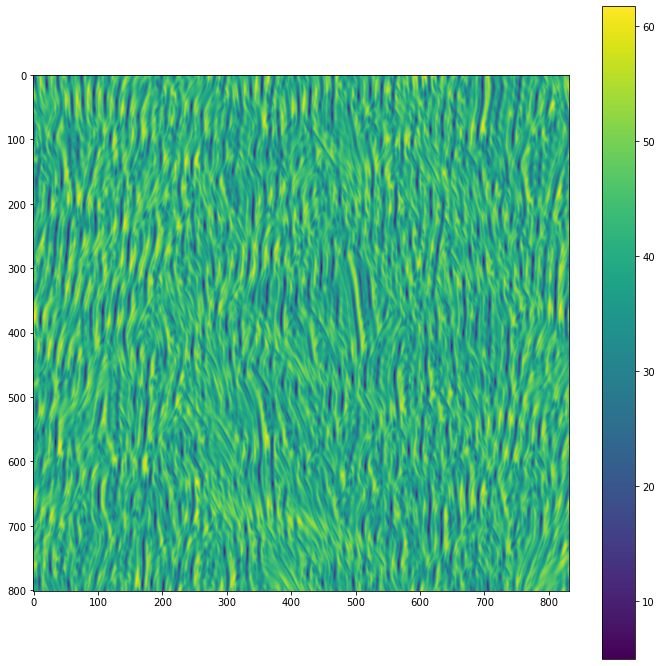

In [10]:
minimal_orbits = orb.read_h5('./data/minimal_cover.h5')
base = orb.read_h5('./data/large_patch.h5')
# base = orb.read_h5('./data/small_patches.h5', '0/')

# Get the less strict thresholds
strictness = 0
critical_l2_diff_values = []
with h5py.File('./data/critical_values.h5', 'r') as file:
    critical_l2_diff_values.append(file['defect/l2_difference_mean_flow_correction'][...][strictness])
    critical_l2_diff_values.append(file['drifter/l2_difference_mean_flow_correction'][...][strictness])
    critical_l2_diff_values.append(file['large_defect/l2_difference_mean_flow_correction'][...][strictness])
    critical_l2_diff_values.append(file['wiggle/l2_difference_mean_flow_correction'][...][strictness])

critical_l2_diff_values_fd = []
with h5py.File('./data/critical_values.h5', 'r') as file:
    critical_l2_diff_values_fd.append(file['defect/l2_difference_mean_flow_correction_fundamental_domain'][...][strictness])
    critical_l2_diff_values_fd.append(file['drifter/l2_difference_mean_flow_correction_fundamental_domain'][...][strictness])
    critical_l2_diff_values_fd.append(file['large_defect/l2_difference_mean_flow_correction_fundamental_domain'][...][strictness])
    critical_l2_diff_values_fd.append(file['wiggle/l2_difference_mean_flow_correction_fundamental_domain'][...][strictness])

windows = [tuple(x.group_orbit(rolls=(12, 12), fundamental_domain=False)) for x in minimal_orbits]
windows_fd = [tuple(x.group_orbit(rolls=(12, 12), fundamental_domain=True)) for x in minimal_orbits]
windows_total = [x for y in windows+windows_fd for x in y]

cvalues = [len(windows[i])*[critical_l2_diff_values[i]/windows[i][0].size] for i in range(len(windows))]
cvalues_fd = [len(windows_fd[i])*[critical_l2_diff_values_fd[i]/windows_fd[i][0].size] for i in range(len(windows_fd))]
cvalues = critical_l2_diff_values + critical_l2_diff_values_fd
windows = minimal_orbits + [x.to_fundamental_domain() for x in minimal_orbits]
window_keys = np.repeat(np.tile(np.array([[1,2,3,4]]),2), 18)    

scrfunc = orb.scoring_functions('l2_density_mfc')

t0l2=time.time_ns()/10**9
lpc = orb.OrbitCover(base, windows, cvalues, hull=None, core=None,
                     mask=None, periodicity=(False, True), scoring_function=scrfunc)
lpc = orb.cover(lpc,
               replacement=False,
               min_overlap = 1,
               verbose=True)
t1l2=time.time_ns()/10**9
print('\nL2 metric covering took {:.2f} seconds to complete'.format(t1l2-t0l2))

fig, ax = plt.subplots(figsize=(12,12))
im = ax.imshow(lpc.trim().min(axis=0))
plt.colorbar(im, ax=ax)
plt.show()

In [11]:
# import gudhi
# from orbithunter.persistent_homology import persistence_distance, orbit_persistence
# def persistence_from_numpy(array, **kwargs): 
#     periodic_dimensions = kwargs.get('periodic_dimensions', tuple(len(array.shape)*[False]))
#     cubical_complex = gudhi.PeriodicCubicalComplex(dimensions=array.shape,
#                                                 top_dimensional_cells=array.ravel(),
#                                                 periodic_dimensions=(True, True))
#     persistence = cubical_complex.persistence(min_persistence=kwargs.get('min_persistence', 0))
#     if kwargs.get('persistence_format', 'numpy') == 'numpy':
#         return np.array([[x[0], x[1][0], x[1][1]] for x in persistence])
#     else:
#         return persistence
# def window_caching_function(window, **kwargs):
#     # The cached value to use within the scoring function must be calculated within the cover function when
#     # looping over the windows. 
#     return orbit_persistence(window, **{'periodic_dimensions':(True, True), **kwargs})

# def persistence_score(base_slice, window_slice, **kwargs):
#     # Cache the window's persistence as it is constant regardless of the base slice.

#     if kwargs.get('window_cache', None) is None:
#         window_persistence = persistence_from_numpy(window_slice)
#     else:
#         window_persistence = kwargs.get('window_cache', None)
#     # To account for the fact that orbit types will usually be different.
#     return persistence_distance(persistence_from_numpy(base_slice, **kwargs), window_persistence, **kwargs)

# t0p=time.time_ns()/10**9
# pc = orb.OrbitCover(base, fundamental_windows, critical_persistence_values, hull=None, core=None,
#                  mask=None, base_periodicity=(False, False),
#                                              window_caching_function=window_caching_function,
# )
                
# persistence_cover = orb.cover(pc, 
#                               replacement=False,
#                               scoring_function=persistence_score,
#                               verbose=True,
#                               min_persistence=0.1,
#                               boundary_conditions=(True, True)
#                              )
# t1p=time.time_ns()/10**9
# print('\nPersistence metric covering took {:.2f} seconds to complete'.format(t1p-t0p))

In [12]:
# fig, axes = plt.subplots(1,3, figsize=(12,8))
# labels = ['bottleneck distance', 'amplitude difference', 'L2 distance']
# for ax, lab, covertuples in zip(axes.flatten(), labels,
#                                [pc, oc1, oc2]):
#     field = covertuples.trim().min(axis=0)
#     print(field.min())
#     im = ax.imshow(field.astype(float))
#     ax.set_xlabel(lab)
# _ = plt.show()
# _ = plt.close()

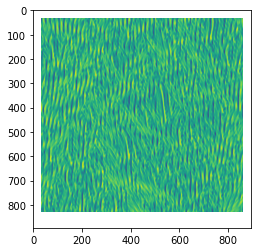

In [13]:
plt.imshow(lpc.scores.min(axis=0))

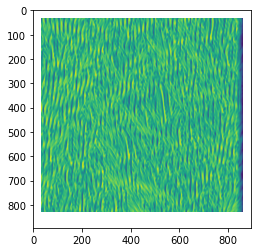

In [64]:
plt.imshow(lpc.scores.min(axis=0))

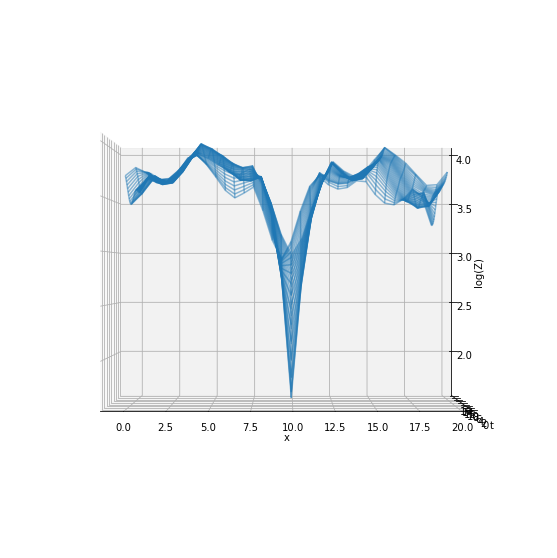

In [14]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(10,10))

sz = 32

min_scores = lpc.scores.min(axis=0)
minwindow = tuple(slice(x-(sz//2), x+(sz//2)) for x in np.unravel_index(min_scores.argmin(), min_scores.shape))
window_around_minimum_score = lpc.scores.min(axis=0)[minwindow]

# Make data.
X = np.linspace(0, sz*large_patch.t/large_patch.n, 32)
Y = np.linspace(0, sz*large_patch.x/large_patch.m, 32)
X, Y = np.meshgrid(X, Y)
Z = window_around_minimum_score

# Plot the surface.
surf = ax.plot_wireframe(X, Y, np.log(Z), alpha=0.5
                      )
ax.view_init(elev=0, azim=-90)
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('log(Z)')
plt.show()

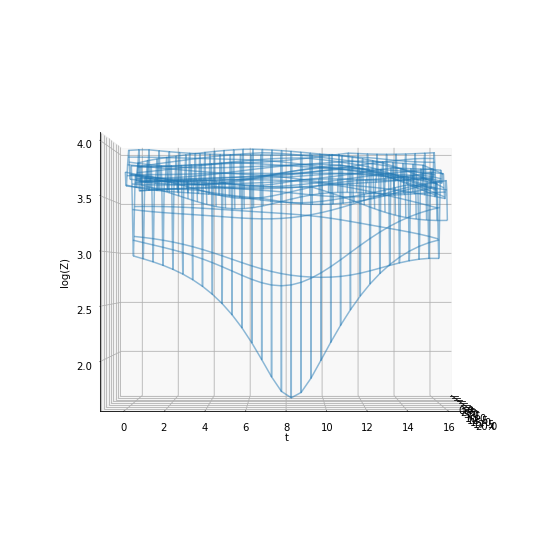

In [15]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(10,10))

sz = 32

min_scores = lpc.scores.min(axis=0)
minwindow = tuple(slice(x-(sz//2), x+(sz//2)) for x in np.unravel_index(min_scores.argmin(), min_scores.shape))
window_around_minimum_score = lpc.scores.min(axis=0)[minwindow]

# Make data.
X = np.linspace(0, sz*large_patch.t/large_patch.n, 32)
Y = np.linspace(0, sz*large_patch.x/large_patch.m, 32)
X, Y = np.meshgrid(X, Y)
Z = window_around_minimum_score

# Plot the surface.
surf = ax.plot_wireframe(X, Y, np.log(Z), alpha=0.5
                      )
ax.view_init(elev=0, azim=0)
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('log(Z)')
plt.show()

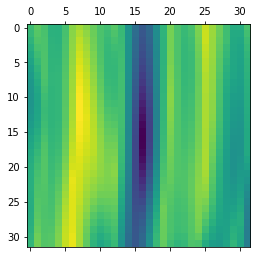

In [16]:
plt.matshow(lpc.scores.min(axis=0)[minwindow])

In [17]:
lpc_trimmed = lpc.trim(non_inf_only=True)
lpc_mapped = lpc.map(verbose=True)

--------------------

In [18]:
from orbithunter.shadowing import pivot_iterator, _subdomain_coordinates, _pad_orbit

In [19]:
lpc_mapped.shape

(8, 832, 832)

In [22]:
# periodicity = (False, False)

# ordered_pivots = pivot_iterator(
#     lpc.scores.shape[1:],
#     lpc.base.shape,
#     lpc.hull,
#     lpc.core,
#     lpc.periodicity,
#     min_overlap=lpc.min_overlap,
#     mask=None,
# )


# # Only have to iterate once per unique discretization shape, take advantage of this.
# all_window_shapes = [tuple(w.discretization) for w in lpc.windows]

# # The bases orbit periodicity has to do with scoring and whether or not to wrap windows around.
# orbit_scores = np.full_like(
#     np.zeros([len(all_window_shapes), *_pad_orbit(lpc.base, lpc.hull, lpc.periodicity).state.shape]), np.inf
# )

# # array_of_window_shapes = np.array(all_window_shapes)
# unique_window_shapes = set(all_window_shapes)
# # By iterating over shapes and not windows, cut down on
# for index, window_shape in enumerate(unique_window_shapes):
#     where_this_shape = tuple(
#         i for i, shape in enumerate(all_window_shapes) if shape == window_shape
#     )
#     # relevant_window_states = np.array([lpc.windows[i].state for i in where_this_shape])
#     # retrieve the function for scoring, using a default function based on the l2 difference.
#     threshold_broadcasting_reshape = tuple([-1] + (len(orbit_scores.shape) - 1) * [1])
#     window_grid = np.indices(window_shape)
    
#     for i, each_pivot in enumerate(ordered_pivots):
#         each_pivot = tuple(each_pivot)
        
#         orbit_coordinates = _subdomain_coordinates(
#             each_pivot,
#             lpc.base.shape,
#             window_shape,
#             window_grid,
#             lpc.hull,
#             lpc.periodicity,
#             coordinate_map=lpc.coordinate_map,
#         )
#         if ((orbit_coordinates[1].max() - orbit_coordinates[1].min())+1) not in [16, 32]:
#             print((orbit_coordinates[1].max() - orbit_coordinates[1].min())+1)
#             break
#     if (orbit_coordinates[1].max() - orbit_coordinates[1].min())+1 not in [16, 32]: 
#         break

In [23]:
# orbit_coordinates = _subdomain_coordinates(
#     each_pivot,
#     lpc.base.shape,
#     window_shape,
#     window_grid,
#     lpc.hull,
#     lpc.periodicity,
#     coordinate_map=lpc.coordinate_map,
# )

In [24]:
# for x in ordered_pivots[-32:, :]:
#     c = _subdomain_coordinates(
#     x,
#     lpc.base.shape,
#     window_shape,
#     window_grid,
#     lpc.hull,
#     lpc.periodicity,
#     coordinate_map=lpc.coordinate_map,
# ) 
#     print(c[0].size, c[1].size)

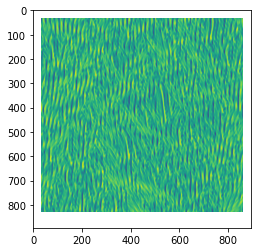

In [30]:
plt.imshow(lpc.scores.min(axis=0))

In [25]:
interactwrapper(lpc, trimmed_scores=lpc_trimmed, mapped_scores=lpc_mapped, mindex=0, maxdex=2)

interactive(children=(IntSlider(value=0, description='orbit_index', max=2), Output()), _dom_classes=('widget-i…

[Return to table of contents](#toc)
# Methodology 

Plot the entire covering, both factorized and the union, and then compare with the "minimal" cover. Which
computes the subset of elements which cover at least a user specified percentage of the *covered* area. **NOT** the total area,
as clearly for "bad" covers this threshold may be unobtainable. If the cover threshold is too strict, then it is likely
that the minimal covering set will be the entire cover; something to keep in mind.

[Return to table of contents](#toc)
<a id='family'></a>
## Overlap between subsampling of a single family. 

Calculate the covers with respect to the 149 different orbits in the large defect family; this takes approximately an hour and a half and so the covers are saved for later use. This uses a large trajectory, produced by time integration, which actually has spatial periodicity. While this takes an exceptional amount of time compared to the smaller base orbits, I believe it is necessary to get an accurate depiction of the number of overlaps. Additionally, the strictest tolerance is used, meaning that detections are expected 0.01% of the time, based on the previously computed distribution. Import these thresholds.

In [ ]:
strictness = 1
critical_l2_diff_values = []
with h5py.File('./data/critical_values.h5', 'r') as file:
    critical_l2_diff_values.append(file['defect/l2_difference_fundamental_domain'][...][strictness])
    critical_l2_diff_values.append(file['drifter/l2_difference_fundamental_domain'][...][strictness])
    critical_l2_diff_values.append(file['large_defect/l2_difference_fundamental_domain'][...][strictness])
    critical_l2_diff_values.append(file['wiggle/l2_difference_fundamental_domain'][...][strictness])

Import the large trajectory segment which will be covered.

In [ ]:
large_defect_family = tuple([x.to_fundamental_domain() for x in orb.read_h5('./data/large_cover.h5', 'large_defect/')])
large_defect_family_critical_values = tuple([critical_l2_diff_values[2]]*len(large_defect_family))

In [ ]:
orbit_cover = orb.OrbitCover(base,
                    large_defect_family,
                    large_defect_family_critical_values,
                    periodicity=(False, True),
                    scoring_function=scrfunc
)

t0fam=time.time_ns()/10**9
large_defect_covering = orb.cover(orbit_cover, verbose=True)
t1fam=time.time_ns()/10**9
print('Family covering took {:.2f} minutes to complete'.format((t1fam-t0fam)/60.))

In [ ]:
periodicity = (False, True)

ordered_pivots = pivot_iterator(
    orbit_cover.scores.shape[1:],
    orbit_cover.base.shape,
    orbit_cover.hull,
    orbit_cover.core,
    periodicity,
    min_overlap=orbit_cover.min_overlap,
    mask=None,
)

testpivots = orbit_cover.padded_orbit.state.copy()
testpivots[ordered_pivots[:,0], ordered_pivots[:,1]] = np.nan
plt.figure(figsize=(5, 5))
plt.imshow(testpivots)
plt.colorbar()
plt.show()

interactwrapper(orbit_cover, trimmed_scores=trimmed, mapped_scores=mapped, mindex=0, maxdex=2)

In [ ]:
plt.imshow(orbit_cover.scores[5])

In [ ]:
trimmed = orbit_cover.trim(non_inf_only=True)
mapped = orbit_cover.map(verbose=True)

In [ ]:
plt.figure(figsize=(20,20))
plt.imshow(orbit_cover.base.state)
plt.colorbar()
plt.show()

In [ ]:
plt.figure(figsize=(20,20))
plt.imshow(orbit_cover.padded_orbit.state)
plt.colorbar()
plt.show()

In [ ]:
plt.figure(figsize=(5,5))
plt.imshow(orbit_cover.padded_orbit.state[:64, :62], interpolation='none')
plt.colorbar()
plt.show()

plt.figure(figsize=(5,5))
plt.imshow(orbit_cover.padded_orbit.state[:64, -62:], interpolation='none')
plt.colorbar()
plt.show()

plt.figure(figsize=(5,5))
plt.imshow(orbit_cover.padded_orbit.state[:64, -62:]-orbit_cover.padded_orbit.state[:64, :62], interpolation='none')
plt.colorbar()
plt.show()

In [ ]:
interactwrapper(orbit_cover, trimmed_scores=trimmed, mapped_scores=mapped, mindex=0, maxdex=2)

Save the covering masks, and produce their "union" in the meantime (here the masks are of integer data and summer so that more overlaps correspond to larger values.).

Compare the minimal covering to the total covering, and see how well this subset (a single mask in this case) reproduces the total mask. What does this mean? It means that instead of 149 different members of a continuous family, only a single representative is needed to reproduce the same results. With this result, we can move to the investigation of the group orbits of these representative.

[Return to table of contents](#toc)
<a id='grouporbit'></a>
## Overlap between subsampling of a single group orbit. 

The next goal is to determine is how much redundancy there is in a cover using a group orbit as a covering set;
that is, the set of symmetry related fields. To test this, the same strictness is applied to 128 group orbit members
of the large defect. 

I think what we will end up using is a hybrid metric which combines $L_2$ distance and persistence diagram distance.

In [ ]:
# fundamental_domain transformation must be done last; therefore take fundamental domains of group orbit not group orbit
# of fundamental_domain. 
large_defect_group_orbit = tuple(windows[2].group_orbit(rolls=(4, 4), fundamental_domain=True))
large_defect_group_orbit_critical_values = tuple([critical_l2_diff_values[2]]*len(large_defect_group_orbit))

In [ ]:
t0g=time.time_ns()
group_orbit_covering = cover(large_patch, large_defect_group_orbit_critical_values, large_defect_group_orbit,
                            scoring_function=l2_difference,
                            replacement=True,
                            base_orbit_periodicity=(False, True),
                            strides=(1, 1),
                            verbose=False)
t1g=time.time_ns()


In [ ]:
print('Group orbit covering took {:.2f} minutes to complete'.format((t1g-t0g)/(10**9 * 60)))

In [ ]:
# Arbitrary number to get cover percentages for plotting. 
cover_threshold=0.99
_, _, percentages = minimal_covering_set(group_orbit_covering, large_patch,
                                         large_defect_group_orbit, cover_threshold,
                                         strides=(1,1), verbose=False)

In [ ]:
plt.plot([0]+list(range(len(percentages))), [0]+percentages)
plt.xlabel('Number of components')
plt.ylabel('Proportion of cover area')
plt.xlim([-5, 80])
plt.ylim([0, 1.1])
plt.show()

Unfortunately, the group orbit does not overlap nearly as much as the continuous family members, indicating that sampling the group orbit (at least with this metric) is very important. To analyze the results of group orbit covering, first find the minimal covering and compare it to the total covering. Then plot the constituents of the covering and their corresponding contributions to the cover. First, look at the dependence on cover percentage vs number of minimal cover constituents.

In [ ]:
cover_threshold=0.8
minimal_covering, minimal_covering_union, _ = minimal_covering_set(group_orbit_covering, large_patch,
                                                                   large_defect_group_orbit,cover_threshold,
                                                                   strides=(1,1), verbose=False)

group_orbit_covering_union = covering_union(group_orbit_covering, large_patch,
                                            large_defect_group_orbit, (1, 1),
#                                            filename='group_orbit_covering_masks.h5',
#                                             groupname='',
                                            dtype=int)

The comparison between the minimal and total cover; the first plot is the minimal cover; higher values indicating more overlaps. The second plot is the full group orbit covering, and the third plot is essentially the difference between the two. 

In [ ]:
compare_cover_plot(minimal_covering_union, group_orbit_covering_union, figsize=(10,10), dtype=int)

#### Check to see that individual orbits are providing sensible coverings 
The constituents or "factors" of the minimal cover of the cover resulting from the group orbit cover. 

In [ ]:
plot_covering_factors(minimal_covering, large_patch, large_defect_group_orbit,
              strides=(1,1), verbose=True,  figsize=(12,12))

This minimal cover is comprised of 16 constituents; this is used as a guideline and so here on out, the translations used to produce the group orbit of each covering orbit yields 18 group orbit members. The relative equilibria and wiggle with have redundant members but it is left this way for simplicity. 

[Return to table of contents](#toc)
<a id='minimal'></a>
# 'Full search' using the previous results 

Now that we have some idea as to how many family and group orbit members we need for a covering, let's go full bore so that we may compare the overlaps between different families.

In [ ]:
minimal_cover = read_h5('minimal_cover.h5')

strictness = 1
critical_values = []
with h5py.File('critical_values.h5', 'r') as file:
    critical_values.append(file['defect/l2_difference'][...][strictness])
    critical_values.append(file['drifter/l2_difference'][...][strictness])
    critical_values.append(file['large_defect/l2_difference'][...][strictness])
    critical_values.append(file['wiggle/l2_difference'][...][strictness])

In [ ]:
for orbit_ in minimal_cover:
    orbit_.plot()

<a id='minimal1'></a>
#### 4.a Orbit covers with fundamental_domain==False
For the first major computation, use the minimal covering consisting of the wiggle, defects of different sizes, and relative equilibrium or "drifter" solution. This computation will iterate over the families both in and out of the fundamental domains as it is not clear which is correct. These computations use the strictest thresholds, requiring scores to be in the bottom 0.01% of the L2 distance distributions in the previous notebooks. First, do not use the fundamental domains of each orbit. Why? This is the impromptu and crude method for attempting to capture local spatial drift velocity. Looking for the orbits in the comoving frame vs. in the full space.

In [ ]:
# covers = []
# cover_families
# t0_full_cover = time.time_ns()/10**9
# for root, l2_cval in zip(minimal_cover, critical_values):
#     # actually single orbits, put into tuple to abide by requirements. 
#     family = tuple(root.group_orbit(rolls=(12, 12), fundamental_domain=False))
#     family_critical_values = tuple([l2_cval]*len(family))
#     family_covering = cover(large_patch, family_critical_values, family,
#                             score_type='pointwise',
#                             scoring_function=l2_difference,
#                             replacement=False,
#                             base_orbit_periodicity=(False, True),
#                             strides=(1,1),
#                             verbose=False)
#     cover_families.append(family)    
#     covers.append(family_covering)

# t1_full_cover = time.time_ns()/10**9

# # Reorganization of results for future computations; essentially merging the currently distinct coverings.
# cover_orbits_collection = []
# cover_collection = []
# i = 0 
# for c, root in zip(covers, minimal_cover):
#     fam = tuple(root.group_orbit(rolls=(12, 12), fundamental_domain=False))
#     for keys in c:
#         entire_covering[i] = c[keys]
#         covering_orbits.append(fam[keys])
#         i += 1
#     cover_orbits_collection.append(fam)
#     cover_collection.append(c)

In [ ]:
print('Group orbit covering took {:.2f} minutes to complete'.format((t1_full_cover-t0_full_cover)/(60)))

[Return to table of contents](#toc)
### Visualize these covers and the factors that contribute to their minimal subsets.
This requires many plots: [skip to the next computation](#skip1). For each family, the plots of
the minimal covering and its comparison to the full cover are provided, followed by the factors in the
minimal covering and their contributions. **The main takeaway here is that 

In [ ]:
labels = ['defect', 'drifter', 'large_defect', 'wiggle']

all_families_cover = {}
for i, (family_cover, family) in enumerate(zip(covers, cover_families)):
    print('Minimal cover of the {} family and its factors'.format(labels[i]))
    cover_threshold=0.8
    family_critical_values = tuple([l2_cval]*len(family))
    
    minimal_covering, minimal_covering_union, _ = minimal_covering_set(family_cover, large_patch,
                                                                       family, cover_threshold,
                                                                       strides=(1,1), verbose=False)

    family_cover_union = covering_union(family_cover, large_patch,
                                                   family, strides, dtype=int)
    all_families_cover[i] = family_cover_union
    compare_cover_plot(minimal_covering_union, family_cover_union, figsize=(10,10), dtype=int)

    plot_covering_factors(minimal_covering, large_patch, family,
                  strides=(1,1), verbose=True, figsize=(12,12))  
    


<a id='minimal2'></a>
#### 4.b Orbit covers with fundamental_domain==True
<a id='skip1'></a>

In [ ]:
strictness = 0
critical_values_fd = []
with h5py.File('critical_values.h5', 'r') as file:
    critical_values_fd.append(file['defect/l2_difference_fundamental_domain'][...][strictness])
    critical_values_fd.append(file['drifter/l2_difference_fundamental_domain'][...][strictness])
    critical_values_fd.append(file['large_defect/l2_difference_fundamental_domain'][...][strictness])
    critical_values_fd.append(file['wiggle/l2_difference_fundamental_domain'][...][strictness])


In [ ]:
for orbit in minimal_cover:
    orbit.plot(fundamental_domain=True)

#### Only run this next cell if covers have not been saved. 

In [ ]:
# covers_fd = []
# cover_fd_families = []
# t0_full_cover_fd = time.time_ns()/10**9
# for root, l2_cval_fd in zip(minimal_cover, critical_values_fd):
#     # actually single orbits, put into tuple to abide by requirements. 
#     family_fd = tuple(root.group_orbit(rolls=(12, 12), fundamental_domain=True))
#     family_fd_critical_values = tuple([l2_cval_fd]*len(family_fd))
#     family_fd_covering = cover(large_patch, family_fd_critical_values, family_fd,
#                                 score_type='pointwise',
#                                 scoring_function=l2_difference,
#                                 replacement=False,
#                                 base_orbit_periodicity=(False, True),
#                                 strides=(1,1),
#                                 verbose=False)
#     cover_fd_families.append(family_fd)
#     covers_fd.append(family_fd_covering)

# t1_full_cover_fd = time.time_ns()/10**9

# labels = ['defect_fd', 'drifter_fd', 'large_defect_fd', 'wiggle_fd']
# for lab, fam, cov in zip(labels, cover_fd_families, covers_fd):
#     covering_union(cov, large_patch, fam, (1, 1),
#                filename='large_patch_complete_covering.h5', groupname=lab, dtype=int)

# # reorganization for future computations; ignore. 
# entire_covering = {}
# covering_orbits = []
# i = 0 
# for c, fam in zip(covers_fd, cover_fd_families):
#     for keys in c:
#         entire_covering_fd[i] = c[keys]
#         covering_fd_orbits.append(fam[keys])
#         i += 1
#     cover_orbits_collection.append(fam)
#     cover_collection.append(c)

[Return to table of contents](#toc)
<a id='skip1'></a>
### Visualize these covers and the factors that contribute to their minimal subsets.
This requires many plots: [skip to the next computation](#skip2). For each family, the plots of
the minimal covering and its comparison to the full cover are provided, followed by the factors in the
minimal covering and their contributions.

#### Each family separately
Excluded because it is similar to before and just clutters the already cluttered notebook.

In [ ]:
# for i, (family_cover_fd, family_fd) in enumerate(zip(covers_fd, cover_fd_families)):
#     cover_threshold=0.8
#     minimal_covering_fd, minimal_covering_union_fd, _ = minimal_covering_set(family_cover_fd, large_patch,
#                                                                        family_fd, cover_threshold,
#                                                                        strides=(1,1), verbose=False)

#     family_cover_union_fd = covering_union(family_cover_fd, large_patch,
#                                                    family_fd, strides, dtype=int)
#     compare_cover_plot(minimal_covering_union_fd, family_cover_union_fd, figsize=(10,10), dtype=int)
#     plot_covering_factors(minimal_covering_fd, large_patch, family_fd,
#                           strides=(1,1), verbose=True,  figsize=(12,12))  
#     all_families_cover[i+4] = family_cover_union_fd

#### All families

In [ ]:
cover_threshold = 0.8
minimal_covering_fd, minimal_covering_fd_union, _ = minimal_covering_set(entire_covering_fd, large_patch,
                                                                   covering_fd_orbits, cover_threshold,
                                                                   strides=(1,1), verbose=False)

entire_covering_fd_union = covering_union(entire_covering_fd, large_patch,
                                          covering_fd_orbits, strides, dtype=int)

In [ ]:
compare_cover_plot(minimal_covering_fd_union, entire_covering_fd_union, figsize=(10,10), dtype=int)

<a id='skip2'></a>
#### Combined results
Now finally look at the combination of all results up until this point; this computation does not look
at the differences or relationships between families

In [ ]:
total_cover = {i:m for i, m in enumerate(list(entire_covering_fd.values())+list(entire_covering.values()))}
total_covering_orbits = covering_orbits + covering_fd_orbits

total_cover_threshold = 0.8
minimal_total_covering, minimal_total_covering_union, _ = minimal_covering_set(total_cover, large_patch,
                                                                   total_covering_orbits, total_cover_threshold,
                                                                   strides=(1,1), verbose=False)

Compare the minimal cover with the total cover; note that by definition the overlap percentage will be approximately 80%. 

In [ ]:
compare_cover_plot(minimal_total_covering_union,
                   covering_union(total_cover,
                                  large_patch,
                                  total_covering_orbits),
                   figsize=(10,10), dtype=bool)

Which yields the following as the 'final' result, which is plots of the original patch, the remainder after covering, and the covering, respectively.

In [ ]:
plot_covering_union(minimal_total_covering, large_patch, total_covering_orbits,
                    strides=(1,1), verbose=True, figsize=(12,12))  

## 5. Current difficulties
<a id='results'></a>

It's clear from the previous plot that the entirety of space-time is not being covered. Even if the threshold on the $L_2$ distance was more lax I do not think these regions would be captured even then. 

The two main issues right now:

1. Overlap between different families
2. Drifting regions. 
3. Patterns not in cover
How much overlap is there between all of the masks? This is what determines whether or not the $L_2$ difference is a sufficient metric; if space-time is being misclassified as shadowing multiple (fundamentally different) families, then we are in trouble.

In [ ]:
covering_summation = []
for i, (cover, orbits) in enumerate(zip(cover_collection, cover_orbits_collection)):
    if covering_summation is None:
        covering_summation.append(covering_union(cover, large_patch, orbits, dtype=bool).astype(int))
    else:
        covering_summation.append(covering_union(cover, large_patch, orbits, dtype=bool).astype(int))

defect_covers = np.sum(np.array(covering_summation)[[0,2,4,6]], axis=0).astype(bool).astype(int)
drifter_covers = np.sum(np.array(covering_summation)[[1, 5]], axis=0).astype(bool).astype(int)
wiggle_covers = np.sum(np.array(covering_summation)[[3, 7]], axis=0).astype(bool).astype(int)


overlap_summed = defect_covers + wiggle_covers + drifter_covers
# overlap_summed[overlap_summed<2] = False
bool_mask = overlap_summed.astype(bool)

overlap_summed[overlap_summed<2] = False
bool_mask = overlap_summed.astype(bool)

_ = plt.figure(figsize=(10,10))
_ = plt.imshow(overlap_summed, vmin=0, vmax=3)
_ = plt.colorbar()
_ = plt.show()
_ = plt.close()

# bool_mask = overlap_summed.astype(bool)
_ = plt.figure(figsize=(10,10))
_ = plt.imshow(np.ma.masked_array(large_patch.state, mask=np.invert(bool_mask)), cmap='jet')
_ = plt.colorbar()
_ = plt.show()
_ = plt.close()

I would say that this requires more work; the majority of the overlap is coming from the drifter overlapping the defect orbit, however. Because the drifter can be reached by continuation from the defect, it is not entirely unexpected, however, the solutions are distinct enough that a way forward to eliminate these overlaps is required. 

#### "Drifting regions"
The previous plot supports my hypothesis that regions with local non-zero galilean velocity/regions with high spatial drift speed seem to not be captured by the current cover. These regions are (by my eye at least) "more blue" or "more red" on average, in terms of the local field values; alternatively they contain "slanted" versions of the current cover. The way to handle this is non-trivial but I have an idea towards its implementation. 

To handle "slanted" manifestations of fundamental orbits (for pointwise metrics) I believe the most convenient method for computation (of the $L_2$ difference at least) is to embedded a parallelogram inside a larger rectangle formed by zero padding.
With these parallelogram embedded in the square, the large patch orbit can be masked with a similarly shaped boolean array. Then the $L_2$ difference between the two can be computed. An example is provided below; a clipping, a parallelogram clipping from the first clipping, and finally the defect orbit manipulated into a parallelogram. The defect orbits' galilean velocity has been set to that of the first patch. 

In [ ]:
shift = 8
def parallelipiped_map(coordinates):
    # Coordinates are (d, *orbit.shape) dimensional indices.
    # Only have to map "x" coordinates; those are the columns.
    t_indices = coordinates[0]
    t_indices
    # use broadcasting by reshaping into n_components = size//shift 
    broadcasting = np.arange(-shift//2, shift//2)
    t_indices.reshape((size//shift, *t_indices.shape))
    #     for each_dimension in coordinates:
        # Have to add discrete numbers, 1 roll per row is way too much.
        


In [ ]:
space_padded_state =np.pad(minimal_cover[0].resize(128,128).change_reference_frame(to='physical').state-0.38, 
                  ((64,64),(128,128)))

shp = space_padded_state.shape[0]//2
for i in range(0, shp):
    space_padded_state[i,:] = np.roll(space_padded_state[i,:].reshape(1,-1), -(shp-i), axis=1)
for i in range(-1, -shp, -1):
    space_padded_state[i,:] = np.roll(space_padded_state[i,:].reshape(1,-1), (shp+i), axis=1)
    
parallelogram = space_padded_state.copy()
blue_shifted = clip(large_patch.roll(-10, axis=1).roll(4, axis=0), ((60, 100), (22, 26)))
umin, umax = blue_shifted.state.min(), blue_shifted.state.max()
maxval = np.max(np.abs([umin, umax]))
blue_shifted_state = blue_shifted.resize(*parallelogram.shape).state
parallelogram_mask = parallelogram.astype(bool)
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(9,3))
ax0.imshow(blue_shifted_state, cmap='jet', vmin=-maxval, vmax=maxval)
ax1.imshow(parallelogram_mask*blue_shifted_state, cmap='jet', vmin=-maxval, vmax=maxval)
im = ax2.imshow(parallelogram, cmap='jet', vmin=-maxval, vmax=maxval)
plt.colorbar(im)

This type of manipulation seemed quite hard, so instead I implemented a "coordinate mapping" method. By providing a function as via the keyword argument ```coordinate_map```, any function that can be applied to an array representing the (integer lattice) positions within the cube can be used. Then, once mapped, the coordinates of the mapped shape are checked for validity before
being used in scoring. 

This not only allows the use of parallelograms but also partial subdomains of these parallelograms, and other arbitrarily complex shapes. This is demonstrated below. This comes with a price, of course, which is the computation time. 